Concrete Crack Detection using Convolutional Neural Network

This project uses convolutional neural network to classify concrete images with/without significant crack.

The dataset and images are downloaded from Mendeley Data:

Özgenel, Çağlar Fırat (2018), “Concrete Crack Images for Classification”, Mendeley Data, v1 http://dx.doi.org/10.17632/5y9wdsg2zt.1

Dataset: Concrete Crack Images for Classification

File: Concrete Crack Images for Classification

DOI: http://dx.doi.org/10.17632/5y9wdsg2zt.1#file-c0d86f9f-852e-4d00-bf45-9a0e24e3b932

Using the Pytorch, a Convolutional Neural Network model was trained on the scaled down images of concrete labeled as "Positive" or "Negative" for concrete surfaces with/without crack.

The dataset consists of 40000 concrete surface images split in 20000 images labeled "Positive" and 20000 images labeled "Negative". The images have been reduced in size by pre-processing through notebook named image_process.

In [1]:
print("Importing libraries...")

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

import h5py

print("Libraries imported!!")

Importing libraries...
Libraries imported!!


In [2]:
#img_size = 32

print("Loading the data...")
#modify path accordingly
hf = h5py.File('.../concrete_crack_image_data.h5', 'r') 
X = np.array(hf.get('X_concrete'))
y = np.array(hf.get('y_concrete'))
hf.close()
print("Data successfully loaded!")

print("Scaling the data...!")
X = X / 255
print("Data successfully scaled!")

Loading the data...
Data successfully loaded!
Scaling the data...!
Data successfully scaled!


In [3]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 3, 1)  
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(6*6*16, 100)   
        self.fc2 = nn.Linear(100, 2)
        #self.dropout = nn.Dropout(1)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 6*6*16)
        X = F.relu(self.fc1(X))
        X = self.fc2(X)
        return F.log_softmax(X, dim=1) 

In [4]:
torch.manual_seed(101)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=2, bias=True)
)

Train set and test set preparation

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=101)

In [6]:
X_train = torch.tensor(X_train).float()
X_train= X_train.view(-1, 1, 32, 32)
y_train = torch.tensor(y_train, dtype=torch.long)

In [7]:
X_test = torch.tensor(X_test).float()
X_test= X_test.view(-1, 1, 32, 32)
y_test = torch.tensor(y_test, dtype=torch.long)

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

As the runnig time for batch gradient descent is within seconds per run, mini batching was not necessary, but higher number of epochs were used.
The format of the pictures are simple compared to complicated object classifications and hence, an acceptable level of testing accurray is achieved without the need to have a cross validation set of data and tuning parameters. 

In [9]:
epochs = 100
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Apply the model
    y_pred = model(X_train)  
    loss = criterion(y_pred, y_train)
 
    # Counting number of correct predictions
    predicted = torch.max(y_pred.data, 1)[1]
    batch_corr = (predicted == y_train).sum()
    trn_corr += batch_corr
        
    # Update parameters
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
        
    train_losses.append(loss)
    train_correct.append(trn_corr)    
    
    print(f'{i+1} of {epochs} epochs completed', f'loss:{loss:7.3f}')
    

1 of 100 epochs completed loss:  0.696
2 of 100 epochs completed loss:  0.692
3 of 100 epochs completed loss:  0.691
4 of 100 epochs completed loss:  0.691
5 of 100 epochs completed loss:  0.690
6 of 100 epochs completed loss:  0.688
7 of 100 epochs completed loss:  0.687
8 of 100 epochs completed loss:  0.685
9 of 100 epochs completed loss:  0.684
10 of 100 epochs completed loss:  0.682
11 of 100 epochs completed loss:  0.679
12 of 100 epochs completed loss:  0.677
13 of 100 epochs completed loss:  0.674
14 of 100 epochs completed loss:  0.671
15 of 100 epochs completed loss:  0.667
16 of 100 epochs completed loss:  0.664
17 of 100 epochs completed loss:  0.660
18 of 100 epochs completed loss:  0.655
19 of 100 epochs completed loss:  0.650
20 of 100 epochs completed loss:  0.644
21 of 100 epochs completed loss:  0.639
22 of 100 epochs completed loss:  0.632
23 of 100 epochs completed loss:  0.625
24 of 100 epochs completed loss:  0.617
25 of 100 epochs completed loss:  0.609
26 of 100

Evaluating Accuracy of model

In [10]:
model.eval()

with torch.no_grad():
    correct = 0
    y_val = model(X_test)  
    predicted = torch.max(y_val,1)[1]
    correct += (predicted == y_test).sum()
loss = criterion(y_val, y_test)
print(f'Test accuracy: {correct.item()}/{len(y_test)} = {correct.item()*100/(len(y_test)):7.3f}%', f'loss:{loss:7.3f}')

Test accuracy: 12586/13200 =  95.348% loss:  0.125


Saving the model

In [11]:
torch.save(model, 'concrete_class.pt')

C:\Users\mshak\anaconda3\envs\pytorchenv2\lib\site-packages\torch\serialization.py:256: UserWarning: Couldn't retrieve source code for container of type ConvolutionalNetwork. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [12]:
torch.save(model.state_dict(), 'concrete_classifier.pt')

In [13]:
if len(train_losses) == epochs:
    torch.save(model.state_dict(), 'concrete_classifier.pt')
else:
    print('Model has not been trained. Consider loading a trained model instead.')

Checking the result for sample photos from positive/negative folder

In [14]:
img_size = 32
img_to_predict = "ConcreteImages/Positive/00001.jpg" 

In [15]:
# function to return the correct shape from a image path
def prepare_image(file):
    img = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (img_size, img_size))
    image = np.array(img)
    image = image/225
    image = torch.tensor(image).float()
    image= image.view(-1, 1, img_size, img_size)
    return image

In [16]:
import cv2

In [17]:
def condition(img_to_predict):
    prepare_image(img_to_predict)
    model.eval()
    with torch.no_grad():
        result = model(prepare_image(img_to_predict)).argmax().item()
        if result == 0:
            predicted = 'Positive'
        else:
            predicted = 'Negative'
    print('Predicted condition is ', predicted,' for cracking')

In [18]:
condition(img_to_predict)

Predicted condition is  Positive  for cracking


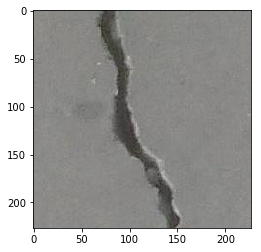

In [19]:
plt.imshow(cv2.imread(img_to_predict))

The process for checking checking condition of any given square photo is saved in notebook named post_process_pytorch.